In [1]:
import os
import shutil
import platform
import subprocess
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import kaggle
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer
from tqdm import trange
import matplotlib.pyplot as plt

Define the paths

In [19]:
kaggle_dir = ".kaggle/"
kaggle_json_path = ".kaggle/kaggle.json"
dataset_url = "danielbacioiu/tig-aluminium-5083"
base_dir = 'kaggle/datasets/al5083'

Kaggle setup

In [7]:
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

shutil.move(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json"))

if platform.system() != 'Windows':
    os.chmod(kaggle_json_path, 0o600)
else:
    os.chmod(kaggle_json_path, 0o400)

print("Setup complete!")

Setup complete!


Download dataset

In [9]:
os.chmod(os.path.expanduser(".kaggle/kaggle.json"), 0o600)
subprocess.run(["kaggle", "datasets", "download", "-d", dataset_url])

print("Dataset download complete!")

Dataset download complete!


Unzip dataset

In [11]:
zip_file = None
for file in os.listdir('.'):
    if file.endswith(".zip"):
        zip_file = file
        break

if zip_file:
    zip_file_path = 'tig-aluminium-5083.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('kaggle/datasets/')
    print("Dataset unzipped successfully!")
    os.remove(zip_file_path)
    print("Zip archive removed!")
else:
    print("No zip file found.")

Dataset unzipped successfully!
Zip archive removed!


In [70]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from tqdm import trange
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load and preprocess data
def load_data(data_path, fraction=1.0):
    images = []
    labels = []
    for root, _, files in os.walk(data_path):
        if fraction < 1.0:
            files = np.random.choice(files, size=int(len(files) * fraction), replace=False)
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize for simplicity
                img = np.array(img) / 255.0  # Normalize pixel values
                img = img.flatten()  # Flatten the image
                images.append(img)
                label = os.path.basename(root)
                labels.append(label)
    return np.array(images), np.array(labels)

base_dir = 'kaggle/datasets/al5083'
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')
X_train, y_train = load_data(train_data_path, fraction=1/5)
X_test, y_test = load_data(test_data_path, fraction=1/5)

unique_labels = np.unique(np.concatenate((y_train, y_test)))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

# Debugging: Check the distribution of classes
print("Class distribution in training data:", np.bincount(y_train))
print("Class distribution in validation data:", np.bincount(y_test))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Class distribution in training data: [216 157 492  46  80 113 174 173  13  22  78   4  17 123  15  23   0  94
   5  47   0   0  90  91   0  42  22   0 168 182   0   0  11 195 233 207
  79   0   0 345 231 322 252   0  94   9   0   0   0 169 154  75  35  74
  16  70  37   0 186  33]
Class distribution in validation data: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  66   0
   0   0  46 126   0   0  47   0   0 117   0   0 130 105   0   0   0   0
   0 242  70   0   0   0   0  80   0   0  30  90  79   0   0   0   0   0
   0   0   0  85]


In [71]:
# Define quantum circuit
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

weight_shapes = {"weights": (6, num_qubits, 3)}

# Define hybrid model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.clayer_1 = nn.Linear(28*28, 128)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.dropout_1 = nn.Dropout(0.5)
        self.clayer_2 = nn.Linear(128, num_qubits)
        self.batch_norm_2 = nn.BatchNorm1d(num_qubits)
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_3 = nn.Linear(num_qubits, len(unique_labels))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.clayer_1(x))
        x = self.batch_norm_1(x)
        x = self.dropout_1(x)
        x = torch.relu(self.clayer_2(x))
        x = self.batch_norm_2(x)
        x = self.qlayer(x)
        x = self.clayer_3(x)
        return self.softmax(x)

model = HybridModel()

In [72]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

# Training loop
num_epochs = 100
batch_size = 32
accuracy_list = []

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
best_model_weights = None

for epoch in trange(num_epochs, desc="Training Progress"):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(val_targets, val_preds)
    accuracy_list.append(acc)
    
    # Reduce learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader):.4f} - Val Loss: {val_loss:.4f} - Accuracy: {acc:.4f}")

c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training Progress:   1%|          | 1/100 [00:13<21:38, 13.12s/it]

Epoch 1 - Loss: 4.0878 - Val Loss: 4.0803 - Accuracy: 0.2051


Training Progress:   2%|▏         | 2/100 [00:26<21:11, 12.98s/it]

Epoch 2 - Loss: 4.0718 - Val Loss: 4.0554 - Accuracy: 0.1910


Training Progress:   3%|▎         | 3/100 [00:38<20:53, 12.92s/it]

Epoch 3 - Loss: 4.0459 - Val Loss: 4.0292 - Accuracy: 0.2041


Training Progress:   4%|▍         | 4/100 [00:51<20:46, 12.99s/it]

Epoch 4 - Loss: 4.0206 - Val Loss: 3.9944 - Accuracy: 0.2041


Training Progress:   5%|▌         | 5/100 [01:04<20:18, 12.83s/it]

Epoch 5 - Loss: 3.9825 - Val Loss: 3.9486 - Accuracy: 0.2041


Training Progress:   6%|▌         | 6/100 [01:17<19:58, 12.75s/it]

Epoch 6 - Loss: 3.9523 - Val Loss: 3.9282 - Accuracy: 0.2041


Training Progress:   7%|▋         | 7/100 [01:29<19:42, 12.71s/it]

Epoch 7 - Loss: 3.9365 - Val Loss: 3.9172 - Accuracy: 0.2041


Training Progress:   8%|▊         | 8/100 [01:42<19:30, 12.72s/it]

Epoch 8 - Loss: 3.9263 - Val Loss: 3.9099 - Accuracy: 0.2041


Training Progress:   9%|▉         | 9/100 [01:55<19:14, 12.69s/it]

Epoch 9 - Loss: 3.9189 - Val Loss: 3.9041 - Accuracy: 0.2041


Training Progress:  10%|█         | 10/100 [02:07<19:00, 12.67s/it]

Epoch 10 - Loss: 3.9122 - Val Loss: 3.8984 - Accuracy: 0.2041


Training Progress:  11%|█         | 11/100 [02:20<18:48, 12.68s/it]

Epoch 11 - Loss: 3.9064 - Val Loss: 3.8923 - Accuracy: 0.2333


Training Progress:  12%|█▏        | 12/100 [02:32<18:32, 12.64s/it]

Epoch 12 - Loss: 3.8992 - Val Loss: 3.8831 - Accuracy: 0.2606


Training Progress:  13%|█▎        | 13/100 [02:45<18:19, 12.64s/it]

Epoch 13 - Loss: 3.8864 - Val Loss: 3.8609 - Accuracy: 0.3020


Training Progress:  14%|█▍        | 14/100 [02:58<18:06, 12.64s/it]

Epoch 14 - Loss: 3.8644 - Val Loss: 3.8415 - Accuracy: 0.3020


Training Progress:  15%|█▌        | 15/100 [03:11<17:59, 12.70s/it]

Epoch 15 - Loss: 3.8473 - Val Loss: 3.8322 - Accuracy: 0.3020


Training Progress:  16%|█▌        | 16/100 [03:24<17:56, 12.82s/it]

Epoch 16 - Loss: 3.8393 - Val Loss: 3.8260 - Accuracy: 0.3020


Training Progress:  17%|█▋        | 17/100 [03:36<17:36, 12.73s/it]

Epoch 17 - Loss: 3.8319 - Val Loss: 3.8194 - Accuracy: 0.3020


Training Progress:  18%|█▊        | 18/100 [03:49<17:27, 12.77s/it]

Epoch 18 - Loss: 3.8225 - Val Loss: 3.8114 - Accuracy: 0.3020


Training Progress:  19%|█▉        | 19/100 [04:02<17:10, 12.73s/it]

Epoch 19 - Loss: 3.8144 - Val Loss: 3.8022 - Accuracy: 0.3452


Training Progress:  20%|██        | 20/100 [04:14<16:52, 12.65s/it]

Epoch 20 - Loss: 3.8042 - Val Loss: 3.7872 - Accuracy: 0.3490


Training Progress:  21%|██        | 21/100 [04:27<16:41, 12.67s/it]

Epoch 21 - Loss: 3.7912 - Val Loss: 3.7751 - Accuracy: 0.3490


Training Progress:  22%|██▏       | 22/100 [04:39<16:23, 12.61s/it]

Epoch 22 - Loss: 3.7835 - Val Loss: 3.7691 - Accuracy: 0.3490


Training Progress:  23%|██▎       | 23/100 [04:52<16:12, 12.63s/it]

Epoch 23 - Loss: 3.7780 - Val Loss: 3.7661 - Accuracy: 0.3490


Training Progress:  24%|██▍       | 24/100 [05:05<15:59, 12.62s/it]

Epoch 24 - Loss: 3.7744 - Val Loss: 3.7627 - Accuracy: 0.3490


Training Progress:  25%|██▌       | 25/100 [05:20<16:40, 13.34s/it]

Epoch 25 - Loss: 3.7709 - Val Loss: 3.7602 - Accuracy: 0.3490


Training Progress:  26%|██▌       | 26/100 [05:35<17:13, 13.96s/it]

Epoch 26 - Loss: 3.7674 - Val Loss: 3.7555 - Accuracy: 0.3490


Training Progress:  27%|██▋       | 27/100 [05:49<16:55, 13.91s/it]

Epoch 27 - Loss: 3.7620 - Val Loss: 3.7456 - Accuracy: 0.3810


Training Progress:  28%|██▊       | 28/100 [06:02<16:27, 13.71s/it]

Epoch 28 - Loss: 3.7520 - Val Loss: 3.7324 - Accuracy: 0.3838


Training Progress:  29%|██▉       | 29/100 [06:17<16:35, 14.02s/it]

Epoch 29 - Loss: 3.7439 - Val Loss: 3.7262 - Accuracy: 0.3838


Training Progress:  30%|███       | 30/100 [06:31<16:18, 13.97s/it]

Epoch 30 - Loss: 3.7395 - Val Loss: 3.7202 - Accuracy: 0.3838


Training Progress:  31%|███       | 31/100 [06:44<15:53, 13.82s/it]

Epoch 31 - Loss: 3.7317 - Val Loss: 3.7114 - Accuracy: 0.4130


Training Progress:  32%|███▏      | 32/100 [06:58<15:39, 13.82s/it]

Epoch 32 - Loss: 3.7247 - Val Loss: 3.7038 - Accuracy: 0.4130


Training Progress:  33%|███▎      | 33/100 [07:11<15:14, 13.65s/it]

Epoch 33 - Loss: 3.7200 - Val Loss: 3.6984 - Accuracy: 0.4130


Training Progress:  34%|███▍      | 34/100 [07:25<15:03, 13.69s/it]

Epoch 34 - Loss: 3.7142 - Val Loss: 3.6932 - Accuracy: 0.4130


Training Progress:  35%|███▌      | 35/100 [07:39<14:47, 13.66s/it]

Epoch 35 - Loss: 3.7104 - Val Loss: 3.6913 - Accuracy: 0.4149


Training Progress:  36%|███▌      | 36/100 [07:52<14:38, 13.72s/it]

Epoch 36 - Loss: 3.7077 - Val Loss: 3.6859 - Accuracy: 0.4224


Training Progress:  37%|███▋      | 37/100 [08:06<14:21, 13.67s/it]

Epoch 37 - Loss: 3.7031 - Val Loss: 3.6822 - Accuracy: 0.4337


Training Progress:  38%|███▊      | 38/100 [08:19<14:02, 13.58s/it]

Epoch 38 - Loss: 3.7012 - Val Loss: 3.6772 - Accuracy: 0.4384


Training Progress:  39%|███▉      | 39/100 [08:33<13:52, 13.65s/it]

Epoch 39 - Loss: 3.6971 - Val Loss: 3.6741 - Accuracy: 0.4440


Training Progress:  40%|████      | 40/100 [08:46<13:31, 13.53s/it]

Epoch 40 - Loss: 3.6922 - Val Loss: 3.6675 - Accuracy: 0.4487


Training Progress:  41%|████      | 41/100 [09:00<13:10, 13.40s/it]

Epoch 41 - Loss: 3.6882 - Val Loss: 3.6624 - Accuracy: 0.4506


Training Progress:  42%|████▏     | 42/100 [09:13<13:02, 13.50s/it]

Epoch 42 - Loss: 3.6839 - Val Loss: 3.6582 - Accuracy: 0.4647


Training Progress:  43%|████▎     | 43/100 [09:27<12:53, 13.57s/it]

Epoch 43 - Loss: 3.6784 - Val Loss: 3.6529 - Accuracy: 0.4788


Training Progress:  44%|████▍     | 44/100 [09:40<12:35, 13.48s/it]

Epoch 44 - Loss: 3.6738 - Val Loss: 3.6460 - Accuracy: 0.4798


Training Progress:  45%|████▌     | 45/100 [09:54<12:18, 13.44s/it]

Epoch 45 - Loss: 3.6655 - Val Loss: 3.6405 - Accuracy: 0.4798


Training Progress:  46%|████▌     | 46/100 [10:07<12:05, 13.44s/it]

Epoch 46 - Loss: 3.6572 - Val Loss: 3.6304 - Accuracy: 0.5061


Training Progress:  47%|████▋     | 47/100 [10:21<12:02, 13.63s/it]

Epoch 47 - Loss: 3.6514 - Val Loss: 3.6282 - Accuracy: 0.5165


Training Progress:  48%|████▊     | 48/100 [10:34<11:39, 13.46s/it]

Epoch 48 - Loss: 3.6447 - Val Loss: 3.6173 - Accuracy: 0.5202


Training Progress:  49%|████▉     | 49/100 [10:48<11:27, 13.47s/it]

Epoch 49 - Loss: 3.6374 - Val Loss: 3.6109 - Accuracy: 0.5381


Training Progress:  50%|█████     | 50/100 [11:01<11:15, 13.51s/it]

Epoch 50 - Loss: 3.6360 - Val Loss: 3.6055 - Accuracy: 0.5673


Training Progress:  51%|█████     | 51/100 [11:14<10:55, 13.38s/it]

Epoch 51 - Loss: 3.6300 - Val Loss: 3.5975 - Accuracy: 0.5786


Training Progress:  52%|█████▏    | 52/100 [11:27<10:33, 13.20s/it]

Epoch 52 - Loss: 3.6217 - Val Loss: 3.5906 - Accuracy: 0.5964


Training Progress:  53%|█████▎    | 53/100 [11:40<10:17, 13.14s/it]

Epoch 53 - Loss: 3.6186 - Val Loss: 3.5740 - Accuracy: 0.5955


Training Progress:  54%|█████▍    | 54/100 [11:54<10:17, 13.41s/it]

Epoch 54 - Loss: 3.6084 - Val Loss: 3.5679 - Accuracy: 0.5917


Training Progress:  55%|█████▌    | 55/100 [12:09<10:17, 13.73s/it]

Epoch 55 - Loss: 3.6001 - Val Loss: 3.5622 - Accuracy: 0.5983


Training Progress:  56%|█████▌    | 56/100 [12:22<09:58, 13.59s/it]

Epoch 56 - Loss: 3.5916 - Val Loss: 3.5539 - Accuracy: 0.6049


Training Progress:  57%|█████▋    | 57/100 [12:36<09:53, 13.79s/it]

Epoch 57 - Loss: 3.5858 - Val Loss: 3.5491 - Accuracy: 0.6209


Training Progress:  58%|█████▊    | 58/100 [12:50<09:37, 13.75s/it]

Epoch 58 - Loss: 3.5843 - Val Loss: 3.5464 - Accuracy: 0.6312


Training Progress:  58%|█████▊    | 58/100 [13:02<09:26, 13.49s/it]


KeyboardInterrupt: 

In [65]:
# Load best model weights
if best_model_weights:
    model.load_state_dict(best_model_weights)

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

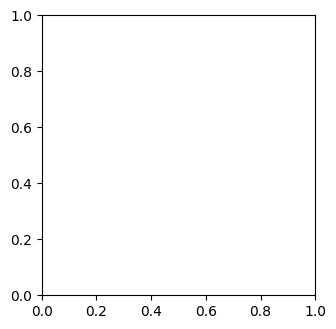

In [66]:
# Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(range(num_epochs), loss_list, label='Training Loss')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(num_epochs), accuracy_list, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(num_epochs), precision_list, label='Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(range(num_epochs), recall_list, label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(range(num_epochs), f1_list, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(range(num_epochs), roc_auc_list, label='ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.title('ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

ValueError: The number of FixedLocator locations (46), usually from a call to set_ticks, does not match the number of labels (60).

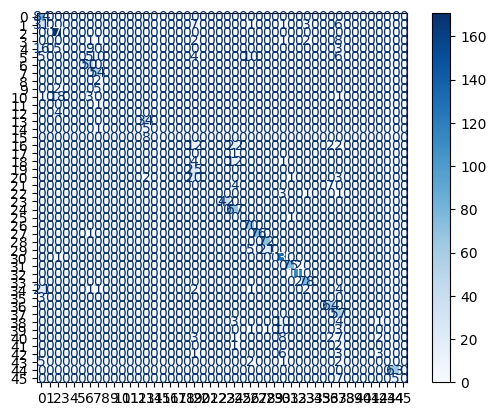

In [67]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

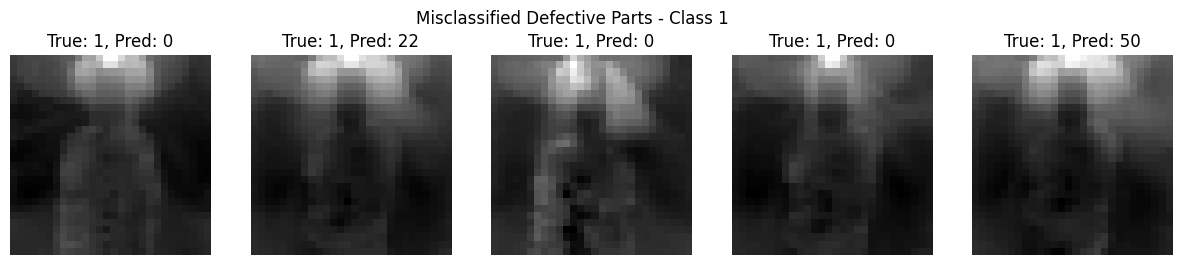

In [68]:
# Visualize some misclassified defective parts
def visualize_misclassified_parts(X_val, y_val, val_preds, class_label):
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_val, val_preds)) if true == class_label and pred != class_label]
    if not misclassified_indices:
        print(f"No misclassified parts for class {class_label}")
        return
    
    fig, axes = plt.subplots(1, min(5, len(misclassified_indices)), figsize=(15, 3))
    for ax, idx in zip(axes, misclassified_indices[:5]):
        img = X_val[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {y_val[idx]}, Pred: {val_preds[idx]}")
        ax.axis('off')
    plt.suptitle(f"Misclassified Defective Parts - Class {class_label}")
    plt.show()

# Assume class 1 is defective part, change if needed
visualize_misclassified_parts(X_val, y_val, val_preds, class_label=1)

Load and preprocess data

In [20]:
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

Load the data

In [18]:
def load_data(data_path, fraction=1.0):
    images = []
    labels = []
    for root, _, files in os.walk(data_path):
        if fraction < 1.0:
            files = np.random.choice(files, size=int(len(files) * fraction), replace=False)
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((28, 28))  # Resize for simplicity
                img = np.array(img).flatten()  # Flatten the image
                images.append(img)
                label = os.path.basename(root)
                labels.append(label)
    return np.array(images), np.array(labels)

Load only 1/3 of the data

In [21]:
X_train, y_train = load_data(train_data_path, fraction=1/3)
X_test, y_test = load_data(test_data_path, fraction=1/3)

Encode the labels

In [22]:
unique_labels = np.unique(np.concatenate((y_train, y_test)))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

Normalize data

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dimensionality reduction

In [24]:
num_qubits = 8
pca = PCA(n_components=num_qubits)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Split data

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Define the quantum device

In [26]:
dev = qml.device("default.qubit", wires=num_qubits)

Define the quantum circuit

In [28]:
def create_quantum_circuit():
    @qml.qnode(dev, interface='autograd')
    def quantum_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
        return qml.expval(qml.PauliZ(0))
    return quantum_circuit

quantum_circuit = create_quantum_circuit()

Define the QNN

In [29]:
def qnn_model(weights, inputs):
    predictions = [quantum_circuit(x, weights) for x in inputs]
    return pnp.array(predictions)

Cost function

In [30]:
def cost(weights, inputs, labels):
    predictions = qnn_model(weights, inputs)
    return pnp.mean((predictions - labels)**2)

Hyperparameters

In [32]:
num_layers = 6
weights = 0.01 * np.random.randn(num_layers, num_qubits, 3)
opt = qml.AdamOptimizer(stepsize=0.01)  # Using Adam optimizer
num_epochs = 50  # Increase the number of epochs
accuracy_list = []

Training

In [33]:
for epoch in trange(num_epochs, desc="Training Progress"):
    weights, cost_val = opt.step_and_cost(lambda w: cost(w, X_train, y_train), weights)
    predictions = qnn_model(weights, X_val)
    acc = accuracy_score(y_val, predictions > 0.5)
    accuracy_list.append(acc)
    print(f"Epoch {epoch+1} - Cost: {cost_val:.4f} - Accuracy: {acc:.4f}")

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:   2%|▏         | 1/50 [04:06<3:21:00, 246.13s/it]

Epoch 1 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:   4%|▍         | 2/50 [08:24<3:22:38, 253.30s/it]

Epoch 2 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:   6%|▌         | 3/50 [2:14:48<47:00:31, 3600.68s/it]

Epoch 3 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:   8%|▊         | 4/50 [2:19:01<29:07:15, 2279.03s/it]

Epoch 4 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  10%|█         | 5/50 [3:26:13<36:23:25, 2911.23s/it]

Epoch 5 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  12%|█▏        | 6/50 [3:30:17<24:29:51, 2004.35s/it]

Epoch 6 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  14%|█▍        | 7/50 [3:34:22<17:04:11, 1429.11s/it]

Epoch 7 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  16%|█▌        | 8/50 [5:57:59<43:22:09, 3717.38s/it]

Epoch 8 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  18%|█▊        | 9/50 [6:02:37<30:05:35, 2642.33s/it]

Epoch 9 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  20%|██        | 10/50 [6:07:07<21:13:14, 1909.87s/it]

Epoch 10 - Cost: 1103.3320 - Accuracy: 0.0434


c:\Users\max_h\anaconda3\envs\myenv_3_9\lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
Training Progress:  20%|██        | 10/50 [6:07:31<24:30:04, 2205.12s/it]


KeyboardInterrupt: 

Evaluate on test set

In [51]:

test_predictions = qnn_model(weights, X_test)
test_accuracy = accuracy_score(y_test, test_predictions > 0.5)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.0000


Identify defective parts

In [52]:

defective_indices = np.where(test_predictions > 0.5)[0]
non_defective_indices = np.where(test_predictions <= 0.5)[0]
print(f"Defective parts indices: {defective_indices}")
print(f"Non-defective parts indices: {non_defective_indices}")

Defective parts indices: [  23   30   72   75   77   80   92  106  114  195  198  204  210  211
  229  234  235  236  238  239  241  255  263  278  285  289  300  307
  315  317  322  325  326  347  348  352  355  370  388  397  405  419
  437  448  449  465  477  484  500  513  518  529  530  535  537  538
  547  548  605  615  616  617  640  641  661  664  667  690  691  708
  754  757  816  860  886  904  905  909  959  967  984  988  989 1003
 1010 1015 1029 1035 1064 1065 1066 1078 1083 1093 1096 1101 1107 1110
 1115 1161 1173 1182 1231 1243 1250 1266 1271 1275 1277 1301 1304 1317
 1329 1330 1344 1346 1361 1374 1382 1392 1396 1412 1414 1452 1478 1480
 1490 1514 1524 1538 1598 1619 1667 1756 1757 1779 1804 1805 1811 1821
 1822 1825 1839 1840 1848 1849 1853 1861 1871 1873 1876 1879 1886 1898
 1946 1955 1958 1990 1996 2039 2074 2080 2083 2087 2110 2180]
Non-defective parts indices: [   0    1    2 ... 2191 2192 2193]


Plotting Accuracy

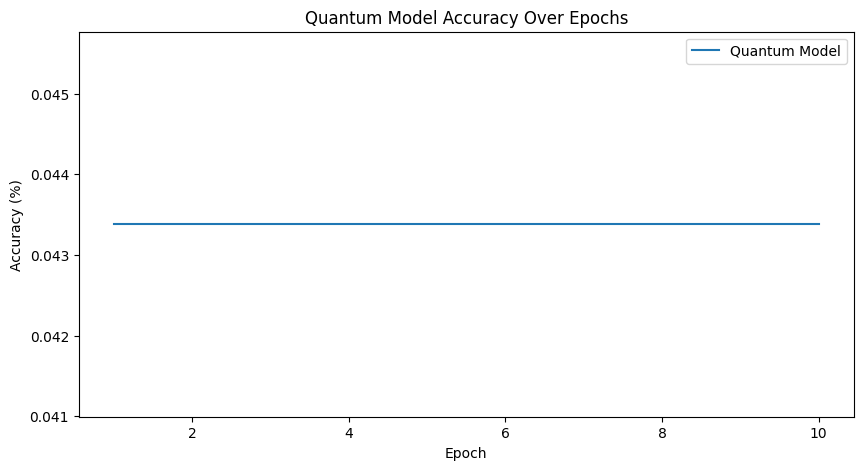

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_list, label='Quantum Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Quantum Model Accuracy Over Epochs')
plt.legend()
plt.show()